In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import trange
import warnings
from itertools import product
# from pmdarima import auto_arima
from tqdm import tqdm  # Импортируем библиотеку tqdm



In [68]:
# источник: https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
def MASE(predicted, actual):
    """
    Вспомогательная функция косинуса
    """
    values = []
    variance = 0
    for i in range(1, len(actual)):
        variance += abs(actual[i] - actual[i - 1])
    variance /= (len(actual) - 1)
    for i in range(len(actual)):
        values.append(abs(actual[i] - predicted[i]) / variance)
    return np.mean(values)

In [69]:
# источник: https://habr.com/ru/companies/glowbyte/articles/542940/
def cos(k, t, l):
    
    """
    Вспомогательная функция косинуса
    """
    
    return math.cos(math.pi*k*t/l)

def get_matrix_and_vector(period_i: np.ndarray) -> (np.ndarray, np.ndarray):
    
    """
    Возвращает матрицу и вектор свободных членов для нахождения коэффициентов Фурье для i-го периода.
    
    period_i - наблюдения i-го периода
    """
    
    N = len(period_i)
        
    y = np.empty((0,))
    matrix = np.empty((0, N))
    
    for t in range(0, N):
        #первое значение в каждой строке 1/2 -- множитель перед коэффициентом a_0
        row = np.array([.5])
        
        for k in range(1, N):
            row = np.append(row, cos(k, t, N-1))

        row = np.reshape(row, (1, N))
        matrix = np.append(matrix, row, axis=0)
        y = np.append(y, period_i[t])
 
    return matrix, y

def solve_system(M: np.ndarray, 
                 b: np.ndarray) -> np.ndarray:
    
    """
    Решает систему линейных уравнений
    M - основная матрица системы
    b - столбец свободных членов
    """
    
    assert np.linalg.det(M) != 0
    return np.linalg.solve(M, b)

def get_matrix_from_series(input_series: pd.Series, 
                           m: int, 
                           l: int):
    """
    Преобразует входной ряд в матрицу, 
    где каждая i-я строка -- наблюдения для i-го периода
    
    input_series -- входной ряд
    m -- количество периодов
    l - длина периода
    """
    
    return input_series.values.reshape(m, l)

def get_delay_matrix(input_vector: np.ndarray, 
                     p: int = 1) -> np.ndarray:
    """
    Строит матрицу задержек по входному вектору и величине задержек
    input_vector - входной вектор
    p - величина задержек
    """
    
    input_vector_copy = np.copy(input_vector)
    
    m = input_vector_copy.shape[0] % p
    
    #если длина ряда не кратна p, то удаляем несколько первых значений ряда
    if m != 0:
        input_vector_copy = np.delete(input_vector_copy, range(m))
    
    #определяем размерность матрицы зарежек
    row_dim = input_vector_copy.shape[0] // p
    col_dim = p
    
    #строим матрицу
    delay_matrix = np.resize(input_vector_copy, 
                             new_shape=(row_dim, col_dim)).T    
    
    return delay_matrix

def find_nearest(row: np.ndarray, 
                 p: int) -> set:
    """
    Возвращает индексы ближайших соседей для последнего элемента строки
    row - входная строка
    p - величина задержек
    """
    
    #количество соседей
    neighbors_cnt = 2 * p + 1
    
    last_element = row[-1]
    all_neighbors = row[:-1]

    #находим индексы ближайших соседей
    idx = set(np.argsort(np.abs(all_neighbors-last_element))[:neighbors_cnt])
        
    return idx

def predict_by_one_step(input_vector: np.ndarray, 
                        p: int = 1) -> float :
    """
    Прогнозирование на один шаг с помощью аналитического решения
    input_vector - входной вектор
    p - величина задержек
    """
    
    delay_matrix = get_delay_matrix(input_vector, p)
    last_row = delay_matrix[-1,:]
    nearest_neighbors_indexes = find_nearest(last_row, p)
    
    y = np.empty((0,))
    X = np.empty((0, p+1))
    for index in nearest_neighbors_indexes:
        y = np.append(y, delay_matrix[0, index+1])
        row = np.append(np.array([1]), delay_matrix[:, index])
        row = np.reshape(row, (1, p+1))
        X = np.append(X, row, axis=0)
    
    coef = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    prediction = sum(np.append(np.array([1]), delay_matrix[:, -1]) * coef)
    
    return prediction

def get_new_fourier_coefs(periods: np.ndarray, 
                          p: int = 1) -> list:
    
    """
    Возвращает коэффициенты Фурье для неизвестного периода
    periods - матрица наблюдений для известных периодов, где i-я строчка -- наблюдения i-го периода
    p - величина задержек
    
    """
    
    #список с предсказанными на след. период коэффициентами
    new_coefs = []
    
    #матрица с коэффициентами Фурье за все периоды. Строки -- коэфициенты за период
    coefs_for_all_periods = []
    
    for period in periods:
        
        X, y = get_matrix_and_vector(period)
        
        #находим коэффициенты Фурье, как решение системы линейных уравнений
        fourier_coef_for_period = solve_system(X, y)
        
        coefs_for_all_periods.append(fourier_coef_for_period)
    
    coefs_for_all_periods = np.array(coefs_for_all_periods)
    
    #Прогноз каждого коэффициента Фурье a_k для неизвестного периода
    #Каждый коэф. Фурье рассматривается как временной ряд, который прогнозируется на один шаг
    for i in range(coefs_for_all_periods.shape[1]):
        coef_for_next_period = predict_by_one_step(coefs_for_all_periods[:, i], p=p)
        new_coefs.append(coef_for_next_period)

    return new_coefs

def predict_next_period(new_coefs: list, 
                        l: int):
    """
    Прогнозирует временной ряд на неизвестный период
    
    new_coefs - коэффициенты Фурье для следующего периода
    l - длина периода
    """
    
    new_period = []
    for t in range(0, l):
        s = new_coefs[0] / 2
        for k in range(1, len(new_coefs)):
            s += new_coefs[k]*cos(k, t, l=l-1)

        new_period.append(s)
    
    return new_period

In [76]:
# функции для прогнозирования с помощью SARIMA
def train_test_split(test_size, df, forecast_periods):
    m_test = round(len(df) * test_size / forecast_periods) # количество периодов в тестовой выборке
    train_test_threshold = len(df) - forecast_periods
    train_start = train_start_point = train_test_threshold % forecast_periods
    train_series = df[:train_test_threshold]
    test_series = df[train_test_threshold:]
    print('Количество наблюдений в обучающей выборке: ', len(train_series),
         '\nКоличество наблюдений в тестовой выборке: ', len(test_series))
    print('\nПервая дата в обучающей выборке ', min(train_series.index), 
          '\nПоследняя дата в обучающей выборке ', max(train_series.index), 
          '\nПервая дата в тестовой выборке ', min(test_series.index), 
          '\nПоследняя дата в тестовой выборке ', max(test_series.index))
    return train_series, test_series
    
def fit_predict_evaluate_SARIMA(train_series, test_series, series_column, order, seasonal_order, forecast_periods):
    test_pred_all = pd.DataFrame()
    mase_all = []
    n_iterations = int(len(test_series) / forecast_periods)  # Количество итераций
    progress_bar = tqdm(range(n_iterations), desc="Прогнозирование", unit="период")  # Прогресс-бар

    for i in progress_bar:
        train_series_temp = pd.concat([train_series, test_series[:i * forecast_periods]], axis=0)
        test_series_temp = test_series[i * forecast_periods:]   

        # Обучаем SARIMA-модель
        model = SARIMAX(train_series_temp[series_column], order=order, seasonal_order=seasonal_order).fit()
        
        # Прогнозируем
        test_pred = model.predict(start=len(train_series_temp) + 1, end=len(train_series_temp) + forecast_periods).to_list()
        test_pred = pd.DataFrame(test_pred[:min(len(test_pred), len(test_series))], 
                                 index=test_series.index[:min(len(test_pred), len(test_series))])
        test_pred_all = pd.concat([test_pred_all, test_pred], axis=0)
        
        # Рассчитываем MASE
        if forecast_periods > 1:
            mase_all.append(round(MASE(np.array(test_pred), np.array(test_series_temp[:len(test_pred)][series_column])), 2))

    if forecast_periods < 2:
        mase_all.append(round(MASE(np.array(test_pred_all), np.array(test_series[series_column])), 2))
    print(f'\nСреднее MASE для {len(mase_all)} тестовых периодов: ', round(np.mean(mase_all), 2))
    
    return test_pred_all
    
def plot_actual_prediction_SARIMA(actual, prediction):
    plt.plot(actual.index, prediction, 'r', label='Прогноз')
    plt.plot(actual.index, actual,'black', label='Факт')
    plt.legend(fontsize=15)
    plt.title('Сравнение прогноза и факта количества нападений в Чикаго', fontsize=15)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Количество нападений', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()
    
def SARIMA_model(test_size, df, series_column, order, seasonal_order, forecast_periods):
    train_series, test_series = train_test_split(test_size, df, forecast_periods)
    test_pred_all = fit_predict_evaluate_SARIMA(train_series, test_series, series_column, order, seasonal_order, forecast_periods)
    plot_actual_prediction_SARIMA(test_series[series_column], test_pred_all)
    return test_pred_all

In [73]:
# функции для прогнозирования с помощью рядов Фурье

# Функция для прогнозирования на один шаг с использованием задержек
def predict_by_one_step(input_vector, p):
    delay_matrix = np.zeros((p, len(input_vector) - p))
    for i in range(p):
        delay_matrix[i, :] = input_vector[i:len(input_vector) - p + i]

    y = input_vector[p:]
    X = np.ones((len(y), p + 1))  # Матрица с первым столбцом из единиц
    for i in range(p):
        X[:, i + 1] = delay_matrix[i, :]  # Добавляем задержки в остальные столбцы

    # Регуляризация для устойчивости вычислений
    regularization = 1e-5  # малое значение
    coef = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + regularization * np.eye(X.shape[1])), X.T), y)

    prediction = sum(np.append(np.array([1]), delay_matrix[:, -1]) * coef)

    return prediction

# Функция для разделения данных на обучающую, промежуточную и тестовую выборки
def custom_train_test_split(l, p, test_size, df):
    m_test = round(len(df) * test_size / l)  # количество периодов в тестовой выборке
    train_test_threshold = len(df) - m_test * l
    train_start = train_test_threshold % l
    train_series = df[train_start:train_test_threshold - (p - 1) * l]
    intermediate_series = df[train_test_threshold - (p - 1) * l:train_test_threshold]
    test_series = df[train_test_threshold:]

    print('Количество наблюдений в обучающей выборке: ', len(train_series),
          '\nКоличество наблюдений в промежуточной выборке: ', len(intermediate_series),
          '\nКоличество наблюдений в тестовой выборке: ', len(test_series))
    print('\nПервая дата в обучающей выборке ', min(train_series.index),
          '\nПоследняя дата в обучающей выборке ', max(train_series.index),
          '\nПервая дата в тестовой выборке ', min(test_series.index),
          '\nПоследняя дата в тестовой выборке ', max(test_series.index))

    return train_series, intermediate_series, test_series

# Основная функция для обучения и прогнозирования
def fit_predict_evaluate_fourier_model(l, p, train_series, intermediate_series, test_series, series_column):
    test_pred_all = pd.DataFrame()
    mase_all = []
    for i in range(int(len(test_series) / l)):
        if len(intermediate_series) > 0 and len(intermediate_series[i * l:]) != 0:
            train_series_temp = pd.concat([train_series, intermediate_series[min(0, (i - 1) * l):i * l]], axis=0)
        else:
            train_series_temp = pd.concat([train_series, test_series[:i * l]], axis=0)
        test_series_temp = test_series[i * l:]

        m_train = int(len(train_series_temp) / l)  # количество периодов в обучающей выборке

        matrix = get_matrix_from_series(train_series_temp[series_column], m_train, l)
        new_coefs = get_new_fourier_coefs(matrix, p)
        test_pred = predict_next_period(new_coefs, l)
        test_pred = pd.DataFrame(test_pred, index=test_series.index[:len(test_pred)])
        test_pred_all = pd.concat([test_pred_all, test_pred], axis=0)

        mase_all.append(round(MASE(np.array(test_pred), np.array(test_series_temp[:len(test_pred)][series_column])), 2))

    print(f'\nСреднее MASE для {len(mase_all)} тестовых периодов: ', round(np.mean(mase_all), 2))

    return test_pred_all

# Функция для визуализации прогноза и фактических данных
def plot_actual_prediction(actual, prediction):
    plt.plot(actual.index, prediction, 'r', label='Прогноз')
    plt.plot(actual.index, actual, 'black', label='Факт')
    plt.legend(fontsize=15)
    plt.title('Сравнение прогноза и факта количества нападений в Чикаго', fontsize=15)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Количество нападений', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Основная функция для работы с рядами Фурье
def fourier_model(l, p, test_size, df, series_column):
    # l - длина периода
    # p - лаг
    train_series, intermediate_series, test_series = custom_train_test_split(l, p, test_size, df)
    test_pred_all = fit_predict_evaluate_fourier_model(l, p, train_series, intermediate_series, test_series, series_column)
    plot_actual_prediction(test_series[series_column], test_pred_all)
    return test_pred_all

In [72]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 13,8.27

In [7]:
crimes_2024 = pd.read_csv('Crimes_-_2024_20241211.csv')

In [8]:
crimes_2024.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13687189,JH536692,12/03/2024 12:00:00 AM,008XX S TRIPP AVE,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,24,26.0,06,NaN,NaN,2024,12/10/2024 03:41:06 PM,NaN,NaN,NaN
1,13687184,JH536701,12/03/2024 12:00:00 AM,008XX S TRIPP AVE,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,24,26.0,06,NaN,NaN,2024,12/10/2024 03:41:06 PM,NaN,NaN,NaN
2,13680756,JH528690,12/03/2024 12:00:00 AM,118XX S UNION AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21,53.0,07,1173779.0,1826377.0,2024,12/10/2024 03:41:06 PM,41.678984,-87.639534,POINT (-87.639533626 41.678984367)
3,13684179,JH533073,12/03/2024 12:00:00 AM,042XX S ARTESIAN AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,False,False,...,12,58.0,26,1160727.0,1876469.0,2024,12/10/2024 03:41:06 PM,41.816723,-87.685930,POINT (-87.685929824 41.816723011)
4,13683203,JH531907,12/03/2024 12:00:00 AM,023XX W 111TH PL,0820,THEFT,$500 AND UNDER,STREET,False,False,...,19,75.0,06,1162695.0,1830599.0,2024,12/10/2024 03:41:06 PM,41.690808,-87.679988,POINT (-87.679988473 41.690808061)


In [9]:
crimes_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237871 entries, 0 to 237870
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    237871 non-null  int64  
 1   Case Number           237871 non-null  object 
 2   Date                  237871 non-null  object 
 3   Block                 237871 non-null  object 
 4   IUCR                  237871 non-null  object 
 5   Primary Type          237871 non-null  object 
 6   Description           237871 non-null  object 
 7   Location Description  236952 non-null  object 
 8   Arrest                237871 non-null  bool   
 9   Domestic              237871 non-null  bool   
 10  Beat                  237871 non-null  int64  
 11  District              237871 non-null  int64  
 12  Ward                  237871 non-null  int64  
 13  Community Area        237869 non-null  float64
 14  FBI Code              237871 non-null  object 
 15  

Посмотрим, что в Чикаго с динамикой преступлений.

In [10]:
crimes_2024['Date'] = pd.to_datetime(crimes_2024['Date'])

C:\Users\User\AppData\Local\Temp\ipykernel_13028\322029557.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crimes_2024['Date'] = pd.to_datetime(crimes_2024['Date'])


In [11]:
crimes_2024['Date'].head(1)

0   2024-12-03
Name: Date, dtype: datetime64[ns]

In [12]:
crimes_2024['Date'].tail(1)

237870   2024-01-01
Name: Date, dtype: datetime64[ns]

У нас данные за один год.

In [13]:
crimes_2024.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13687189,JH536692,2024-12-03,008XX S TRIPP AVE,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,24,26.0,06,NaN,NaN,2024,12/10/2024 03:41:06 PM,NaN,NaN,NaN


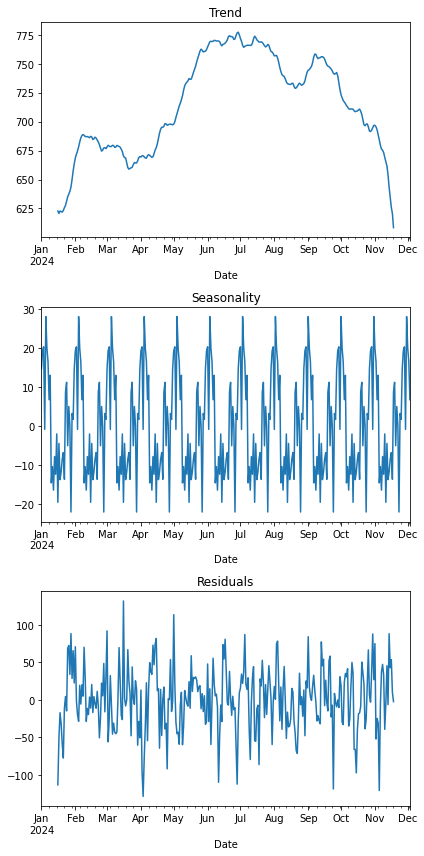

In [14]:
# Создаем копию датасета
crimes_copy = crimes_2024.copy()

# Убедимся, что колонка Date имеет тип datetime
crimes_copy['Date'] = pd.to_datetime(crimes_copy['Date'])

# Агрегируем данные: считаем количество преступлений за каждый день
time_series = crimes_copy.groupby(crimes_copy['Date'].dt.date).size()

# Преобразуем в DataFrame для удобства
time_series = time_series.rename('CrimeCount').to_frame()

# Устанавливаем индекс времени
time_series.index = pd.to_datetime(time_series.index)

# Выполняем декомпозицию временного ряда
decomposed = seasonal_decompose(time_series['CrimeCount'], model='additive', period=30)

# Визуализация декомпозиции
plt.figure(figsize=(6, 12))

# Тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Сезонность
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# Остатки
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

# Настраиваем оформление
plt.tight_layout()
plt.show()

In [15]:
crimes_01_23 = pd.read_csv('Crimes_-_2001_to_Present.csv')

In [16]:
crimes_01_23.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [17]:
crimes_01_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784664 entries, 0 to 7784663
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: bool(2), float64(7), int64(3), object(1

In [18]:
crimes_01_23['Date'] = pd.to_datetime(crimes_01_23['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [19]:
crimes_01_23['Date'].min()

Timestamp('2001-01-01 00:00:00')

In [20]:
crimes_01_23['Date'].max()


Timestamp('2023-04-21 23:59:00')

In [21]:
crimes_13_23 = crimes_01_23[(crimes_01_23['Date'] >= '2013-01-01') & (crimes_01_23['Date'] <= '2023-04-03')]

In [22]:
#crimes_13_23.to_csv('filtered_crimes_2013_2023.csv', index=False)

In [23]:
#crimes_13_23 = pd.read_csv('filtered_crimes_2013_2023.csv')

In [24]:
crimes_13_23.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,2018-09-01 00:01:00,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,2015-09-05 12:45:00,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [25]:
crimes_13_23['Date'] = pd.to_datetime(crimes_13_23['Date'])


# Преобразуем колонку Date_rounded в datetime, если она округлена до дня
crimes_13_23['Date_rounded'] = pd.to_datetime(crimes_13_23['Date'].dt.date)

# Добавляем колонку с неделями (год + номер недели)
crimes_13_23['Week'] = crimes_13_23['Date'].dt.to_period('W').astype(str)

# Добавляем колонку с почасовыми отметками (год, месяц, день, час)
crimes_13_23['Hour'] = crimes_13_23['Date'].dt.floor('H')


# Убедимся, что в датасете есть числовые данные, для которых мы можем выполнить агрегацию
# Например, если мы хотим подсчитать количество преступлений за день, можем использовать метод size()

# Добавляем колонку с неделями (год + номер недели)
crimes_13_23['Week'] = crimes_13_23['Date'].dt.to_period('W').astype(str)

# Добавляем колонку с почасовыми отметками (год, месяц, день, час)
crimes_13_23['Hour'] = crimes_13_23['Date'].dt.floor('H')

# Агрегируем данные по дням
daily_crimes = crimes_13_23.groupby('Date_rounded').size()

# Агрегируем данные по неделям
weekly_crimes = crimes_13_23.groupby('Week').size()

# Агрегируем данные по часам
hourly_crimes = crimes_13_23.groupby('Hour').size()


C:\Users\User\AppData\Local\Temp\ipykernel_13028\4164379207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_13_23['Date'] = pd.to_datetime(crimes_13_23['Date'])
C:\Users\User\AppData\Local\Temp\ipykernel_13028\4164379207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_13_23['Date_rounded'] = pd.to_datetime(crimes_13_23['Date'].dt.date)
C:\Users\User\AppData\Local\Temp\ipykernel_13028\4164379207.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [26]:
daily_crimes.head()

Date_rounded
2013-01-01    1440
2013-01-02     750
2013-01-03     776
2013-01-04     866
2013-01-05     788
dtype: int64

In [27]:
decomposed = seasonal_decompose(daily_crimes)

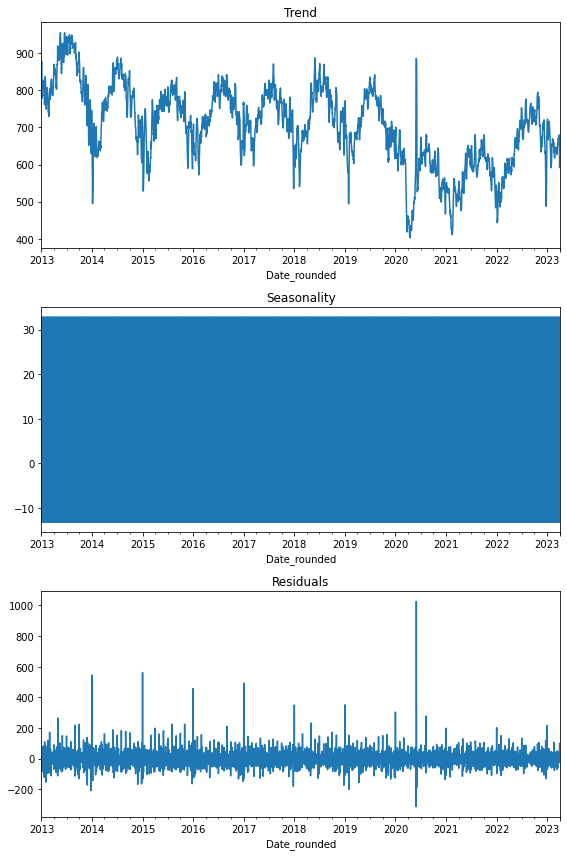

In [28]:
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<Axes: xlabel='Date_rounded'>

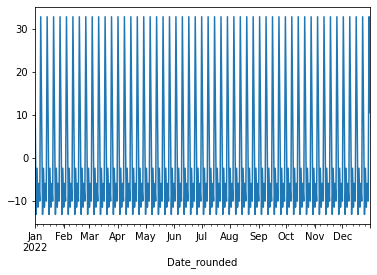

In [29]:
decomposed.seasonal['2022-01-01':'2022-12-31'].plot()

<Axes: xlabel='Date_rounded'>

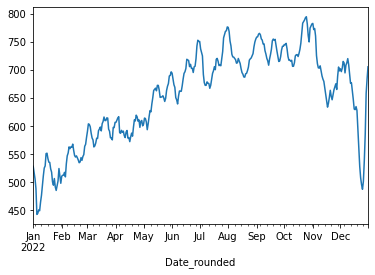

In [30]:
decomposed.trend['2022-01-01':'2022-12-31'].plot()

<Axes: xlabel='Date_rounded'>

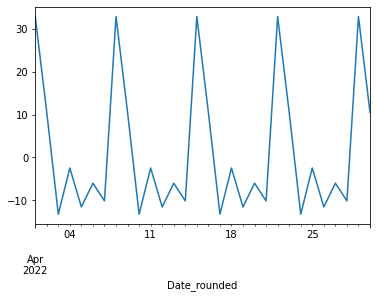

In [31]:
decomposed.seasonal['2022-04-01':'2022-04-30'].plot()

<Axes: xlabel='Date_rounded'>

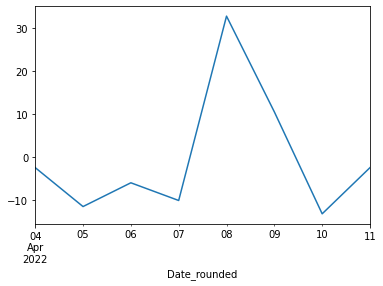

In [32]:
decomposed.seasonal['2022-04-04':'2022-04-11'].plot()

In [33]:
crimes_13_23['Primary Type'].value_counts(normalize=True)

Primary Type
THEFT                                2.252248e-01
BATTERY                              1.835760e-01
CRIMINAL DAMAGE                      1.084510e-01
ASSAULT                              7.412584e-02
DECEPTIVE PRACTICE                   6.813782e-02
OTHER OFFENSE                        6.301693e-02
NARCOTICS                            6.057445e-02
MOTOR VEHICLE THEFT                  4.689371e-02
BURGLARY                             4.519016e-02
ROBBERY                              3.783352e-02
CRIMINAL TRESPASS                    2.349882e-02
WEAPONS VIOLATION                    2.196673e-02
OFFENSE INVOLVING CHILDREN           8.865590e-03
PUBLIC PEACE VIOLATION               6.533119e-03
SEX OFFENSE                          4.291686e-03
INTERFERENCE WITH PUBLIC OFFICER     3.935120e-03
CRIM SEXUAL ASSAULT                  3.544415e-03
PROSTITUTION                         3.138158e-03
HOMICIDE                             2.421992e-03
CRIMINAL SEXUAL ASSAULT              

In [34]:
# #посмотрим на данные по избиениям
# battery = crimes_13_23[crimes_13_23['Primary Type'] == 'BATTERY']

# # Агрегируем данные по дням
# daily_battery = battery.groupby('Date_rounded').size()


# battery_decomposed = seasonal_decompose(daily_battery)

In [35]:
# plt.figure(figsize=(6, 12))
# plt.subplot(311)
# battery_decomposed.trend.plot(ax=plt.gca())
# plt.title('Trend')
# plt.subplot(312)
# battery_decomposed.seasonal.plot(ax=plt.gca())
# plt.title('Seasonality')
# plt.subplot(313)
# battery_decomposed.resid.plot(ax=plt.gca())
# plt.title('Residuals')
# plt.tight_layout()

In [36]:
# battery_decomposed.seasonal['2022-04-01':'2022-04-30'].plot()

Изучим подробнее данные об ASSAULT — нападениях. Угроза или попытка насилия над человеком, не приводящая к серьезным повреждениям.

In [37]:
assault = crimes_13_23[crimes_13_23['Primary Type'] == 'ASSAULT']
daily_assault = assault.groupby('Date_rounded').size()
assault_days_decomposed = seasonal_decompose(daily_assault)

In [38]:
daily_assault.head()

Date_rounded
2013-01-01    39
2013-01-02    39
2013-01-03    45
2013-01-04    35
2013-01-05    43
dtype: int64

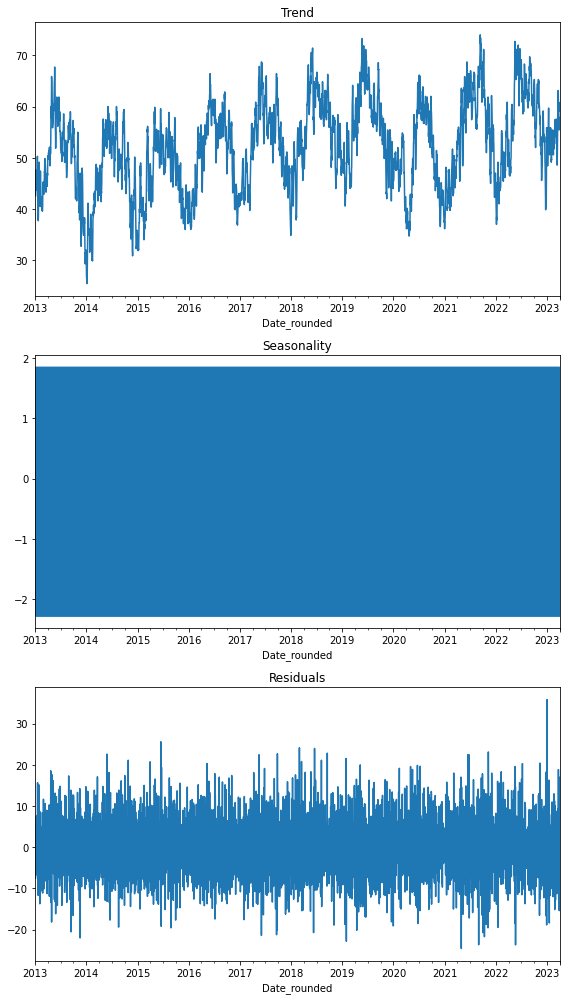

In [39]:
plt.figure(figsize=(8, 14))
plt.subplot(311)
assault_days_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
assault_days_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
assault_days_decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<Axes: xlabel='Date_rounded'>

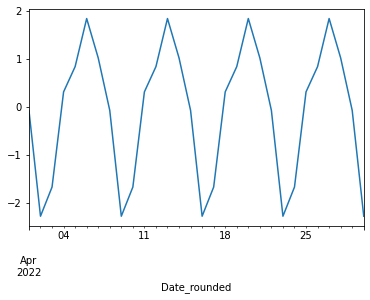

In [40]:
assault_days_decomposed.seasonal['2022-04-01':'2022-04-30'].plot()

<Axes: xlabel='Date_rounded'>

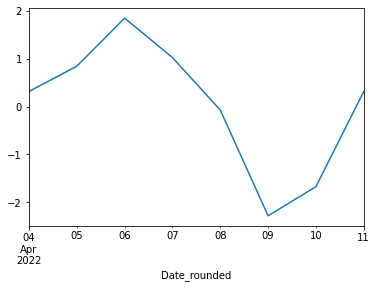

In [41]:
assault_days_decomposed.seasonal['2022-04-04':'2022-04-11'].plot()

In [42]:
# Добавляем колонку с часовым округлением
assault['Hour'] = assault['Date'].dt.floor('H')

# Агрегируем данные по часам
hour_assault = assault.groupby('Hour').size()

# Устанавливаем часовую частоту и заполняем пропуски нулями
hour_assault = hour_assault.asfreq('H', fill_value=0)

# Применяем seasonal_decompose с периодом 24 (суточная сезонность)
assault_hour_decomposed = seasonal_decompose(hour_assault, model='additive', period=24)

C:\Users\User\AppData\Local\Temp\ipykernel_13028\2039944401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assault['Hour'] = assault['Date'].dt.floor('H')


<Axes: xlabel='Hour'>

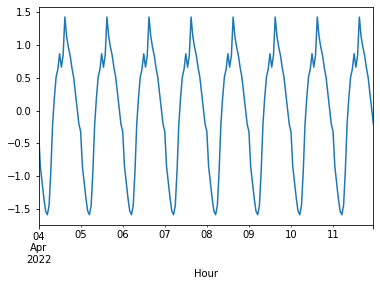

In [43]:
assault_hour_decomposed.seasonal['2022-04-04':'2022-04-11'].plot()

<Axes: xlabel='Hour'>

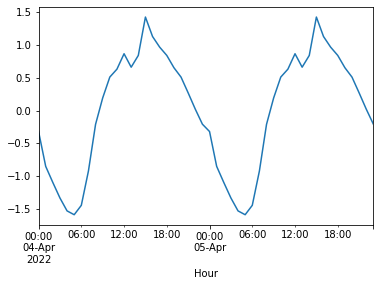

In [44]:
assault_hour_decomposed.seasonal['2022-04-04':'2022-04-05'].plot()

In [45]:

# # Преобразуем индекс в DatetimeIndex (если еще не преобразован)
# daily_homicide.index = pd.to_datetime(daily_homicide.index)

# # Установим частоту для индекса
# daily_homicide = daily_homicide.asfreq('D')


# # Заполнение пропущенных значений нулями
# daily_homicide = daily_homicide.fillna(0)

# # Применение seasonal_decompose
# homicide_decomposed = seasonal_decompose(daily_homicide)

In [46]:
# plt.figure(figsize=(6, 12))
# plt.subplot(311)
# homicide_decomposed.trend.plot(ax=plt.gca())
# plt.title('Trend')
# plt.subplot(312)
# homicide_decomposed.seasonal.plot(ax=plt.gca())
# plt.title('Seasonality')
# plt.subplot(313)
# homicide_decomposed.resid.plot(ax=plt.gca())
# plt.title('Residuals')
# plt.tight_layout()

In [47]:
# homicide_decomposed.seasonal['2022-04-01':'2022-04-30'].plot()

Изучим данные о assault подробнее.

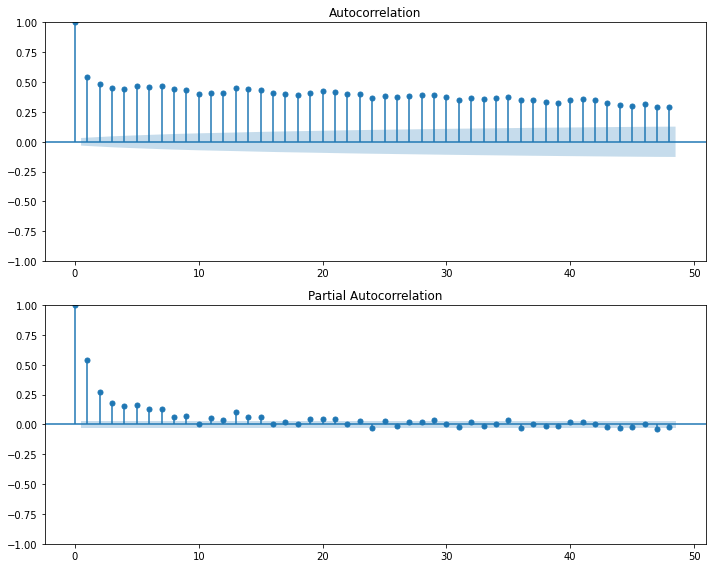

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(daily_assault.values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(daily_assault, lags=48, ax=ax2)
plt.tight_layout()  
plt.show()

График показывает долгосрочную зависимость между днями, но без ярко выраженной сезонности. Волнообразная структура на посуточных данных отсутствует.
Высокая автокорреляция на малых лагах указывает на наличие тренда (например, рост или снижение числа преступлений со временем).

Частичная автокорреляция (PACF):
Несколько значимых лагов в начале указывают на то, что данные зависят от недавних значений, но тренд играет более значимую роль.

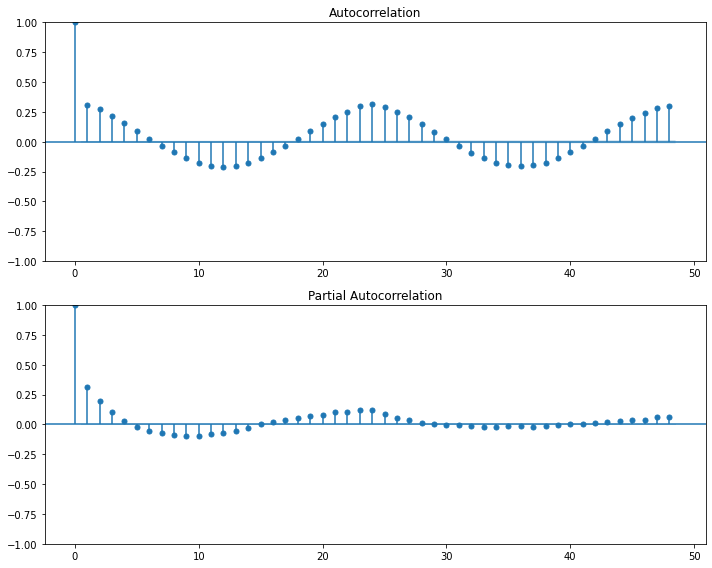

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(hour_assault.values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(hour_assault, lags=48, ax=ax2)
plt.tight_layout()  
plt.show()

Четко видна волнообразная структура с периодом около 24 лагов, что указывает на сильную суточную сезонность. Это логично, так как преступления могут повторяться с одинаковой частотой в определенные часы суток.
Значения автокорреляции постепенно затухают, но сохраняют высокую амплитуду на сезонных интервалах (например, каждые 24 часа).

Частичная автокорреляция (PACF): На первых нескольких лагах присутствуют значимые пики, что может указывать на зависимость от недавних часов.
После этого значения становятся ближе к нулю, что характерно для временных рядов с выраженной сезонностью.

In [50]:
weekly_assault = assault.groupby('Week').size()

In [51]:
weekly_assault_copy = weekly_assault.to_frame()
weekly_assault_copy.rename(columns={weekly_assault_copy.columns[0]: 'num_orders'}, inplace=True)

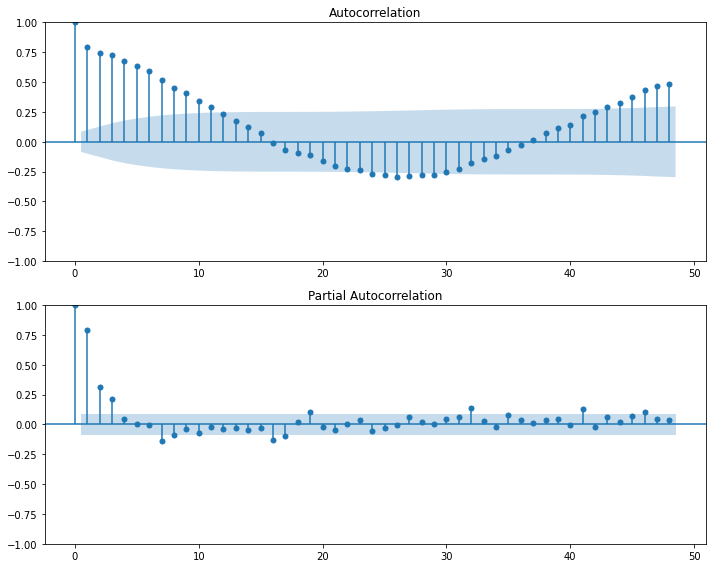

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(weekly_assault.values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(weekly_assault, lags=48, ax=ax2)
plt.tight_layout()  
plt.show()

## Интеграция ряда

In [53]:
daily_assault_diff = daily_assault.diff(periods=1).dropna()

<Axes: xlabel='Date_rounded'>

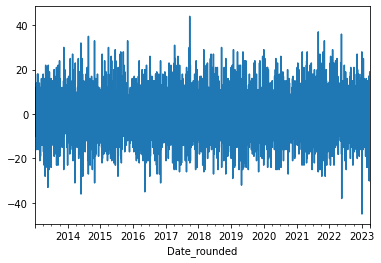

In [54]:
daily_assault_diff.plot()

In [55]:
test = sm.tsa.adfuller(daily_assault_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -17.170652241197054
p-value:  6.746876631536588e-30
Critical values:  {'1%': -3.4321114600792098, '5%': -2.862318315640672, '10%': -2.567184308512469}
единичных корней нет, ряд стационарен


Мы остационарили ряд, убрав тренды и сезонность. Тренды и сезонность мешают моделям видеть реальную зависимость в данных. Например, если преступления в целом растут год за годом, модель может "запутаться" и принять этот рост за закономерность, а не за внешнее влияние.

In [56]:
# Если daily_assault — это Series, преобразуем его в DataFrame
daily_assault_copy = daily_assault.to_frame()

In [57]:
# daily_assault_copy['Date_rounded'] = pd.to_datetime(daily_assault['Date_rounded'])

# # Устанавливаем столбец Date_rounded как индекс
# daily_assault_copy.set_index('Date_rounded', inplace=True)
# Если daily_assault — это Series, преобразуем его в DataFrame
daily_assault_copy = daily_assault.to_frame()
# Переименовываем колонку с цифрами в num_orders
daily_assault_copy.rename(columns={daily_assault_copy.columns[0]: 'num_orders'}, inplace=True)

In [58]:
weekly_assault = assault.groupby('Week').size()

In [59]:
weekly_assault_copy = weekly_assault.to_frame()
weekly_assault_copy.rename(columns={weekly_assault_copy.columns[0]: 'num_orders'}, inplace=True)

In [60]:
weekly_assault_copy.head()

,num_orders
Week,
2012-12-31/2013-01-06,246
2013-01-07/2013-01-13,318
2013-01-14/2013-01-20,352
2013-01-21/2013-01-27,271
2013-01-28/2013-02-03,311


In [61]:
hour_assault_copy = hour_assault.to_frame()
hour_assault_copy.rename(columns={hour_assault_copy.columns[0]: 'num_orders'}, inplace=True)

Количество наблюдений в обучающей выборке:  509 
Количество наблюдений в тестовой выборке:  26

Первая дата в обучающей выборке  2012-12-31/2013-01-06 
Последняя дата в обучающей выборке  2022-09-26/2022-10-02 
Первая дата в тестовой выборке  2022-10-03/2022-10-09 
Последняя дата в тестовой выборке  2023-03-27/2023-04-02


Прогнозирование: 100%|███████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.52s/период]



Среднее MASE для 1 тестовых периодов:  0.84


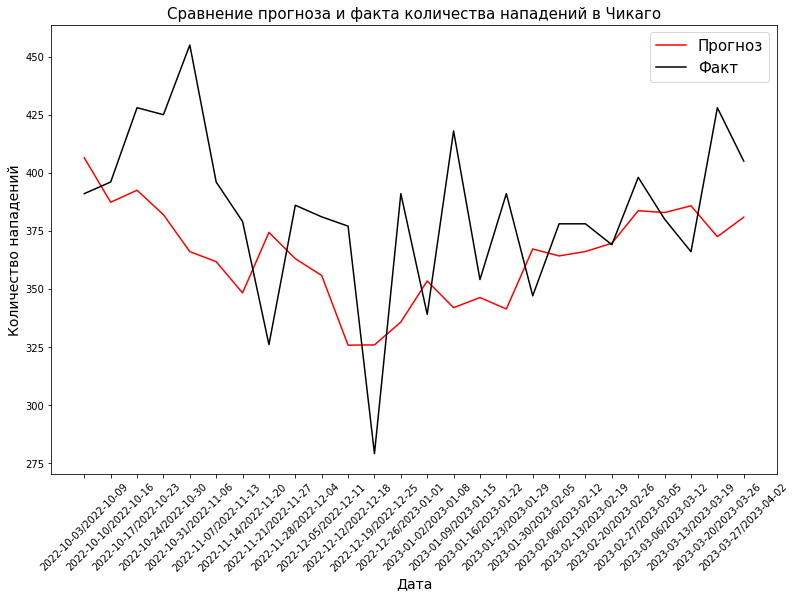

In [77]:
warnings.filterwarnings('ignore')
test_pred_all = SARIMA_model(0.1, weekly_assault_copy, 'num_orders', (1,1,1), (2,1,1,52), 26)
warnings.resetwarnings()

In [64]:
#!pip install pmdarima

In [65]:
# from pmdarima import auto_arima

# # Автоматический подбор параметров
# auto_model = auto_arima(weekly_assault_copy['num_orders'],
#                         seasonal=True, m=52,
#                         stepwise=True, suppress_warnings=True,
#                         trace=True)
# print(auto_model.summary())

In [66]:
# warnings.filterwarnings('ignore')
# test_pred_all = SARIMA_model(0.1, weekly_assault_copy, 'num_orders', (1,1,1), (0,1,1,52), 52)
# warnings.resetwarnings()

Количество наблюдений в обучающей выборке:  3716 
Количество наблюдений в тестовой выборке:  28

Первая дата в обучающей выборке  2013-01-01 00:00:00 
Последняя дата в обучающей выборке  2023-03-05 00:00:00 
Первая дата в тестовой выборке  2023-03-06 00:00:00 
Последняя дата в тестовой выборке  2023-04-02 00:00:00


Прогнозирование: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/период]


Среднее MASE для 1 тестовых периодов:  0.74


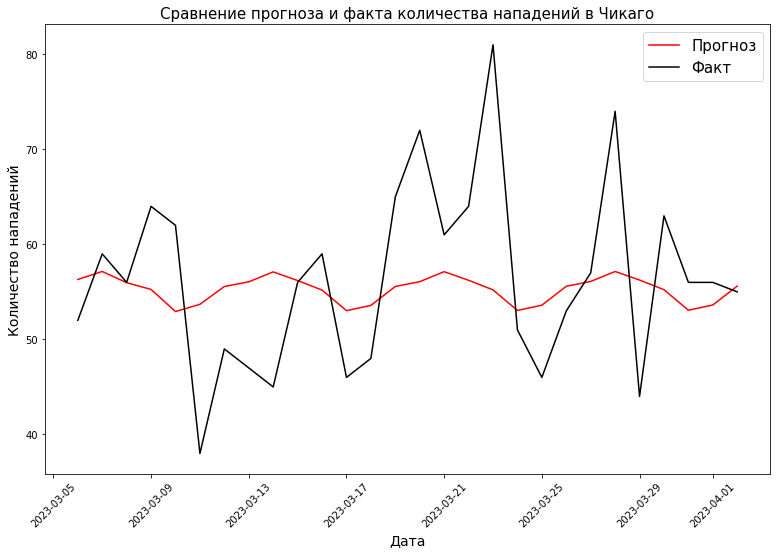

In [94]:
warnings.filterwarnings('ignore')
test_pred_all = SARIMA_model(0.1, daily_assault_copy, 'num_orders', (1,1,1), (1,1,1,7), 28)
warnings.resetwarnings()

Количество наблюдений в обучающей выборке:  3745 
Количество наблюдений в промежуточной выборке:  0 
Количество наблюдений в тестовой выборке:  14

Первая дата в обучающей выборке  2013-01-05 00:00:00 
Последняя дата в обучающей выборке  2023-04-07 00:00:00 
Первая дата в тестовой выборке  2023-04-08 00:00:00 
Последняя дата в тестовой выборке  2023-04-21 00:00:00

Среднее MASE для 2 тестовых периодов:  0.72


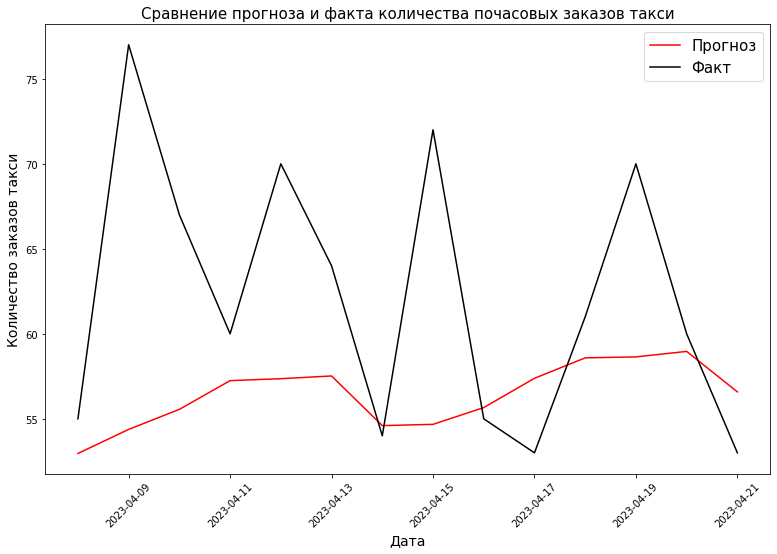

In [82]:
test_pred_all = fourier_model(7, 1, 14 / len(daily_assault_copy), daily_assault_copy, 'num_orders')


Количество наблюдений в обучающей выборке:  504 
Количество наблюдений в промежуточной выборке:  0 
Количество наблюдений в тестовой выборке:  28

Первая дата в обучающей выборке  2013-02-11/2013-02-17 
Последняя дата в обучающей выборке  2022-10-03/2022-10-09 
Первая дата в тестовой выборке  2022-10-10/2022-10-16 
Последняя дата в тестовой выборке  2023-04-17/2023-04-23

Среднее MASE для 4 тестовых периодов:  0.96


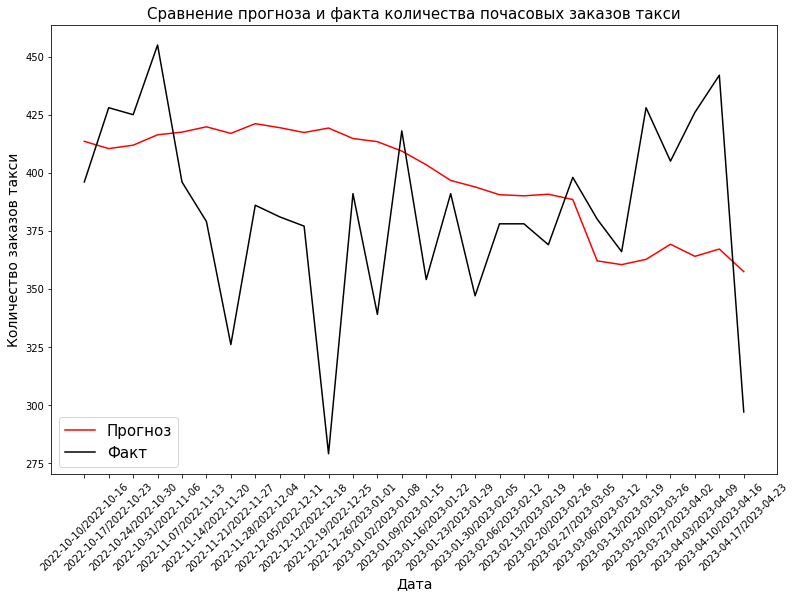

In [83]:
test_pred_all = fourier_model(7, 1, 26 / len(weekly_assault_copy), weekly_assault_copy, 'num_orders')
